In [17]:
%matplotlib inline

import pathlib

import matplotlib.pyplot as plt
plt.style.use('seaborn')
# import seaborn as sns
# sns.set_style('darkgrid')

import numpy as np
import scipy as sp
import scipy.spatial.distance
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn import metrics

In [71]:
L1 = scipy.spatial.distance.cityblock
L2 = scipy.spatial.distance.euclidean


def load_img(path, grey=True):
    pil_img = Image.open(path)
    if grey:
        pil_img = pil_img.convert('LA')
    return np.array(pil_img) / 255.0


# def metric(y_true, y_pred):
#     true_0, true_1 = (y_true == 0), (y_true == 1)
#     pred_0, pred_1 = (y_pred == 0), (y_pred == 1)
#     tp, tn = np.sum(true_1 & pred_1), np.sum(true_0 & pred_0)
#     fp, fn = np.sum(true_0 & pred_1), np.sum(true_1 & pred_0)

#     precision = tp / (tp + fp) if tp + fp > 0 else None
#     recall = tp / (tp + fn) if tp + fn > 0 else None
#     return precision, recall


def pr_curve(y_true, y_score, color='teal'):
    pr, re, th = metrics.precision_recall_curve(y_true, y_score)
    ap = metrics.average_precision_score(y_true, y_score)

    fig, ax = plt.subplots(dpi=100)
    ax.step(re, pr, where='post', alpha=0.5, color='k')
    ax.fill_between(re, pr, step='post', alpha=0.5, color=color)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('AP = {:.3f}'.format(ap))
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    plt.show()
    
    df = pd.DataFrame({
        'th': th,
        'pr': pr[:-1],
        're': re[:-1]
    })    
    return df, ap

In [77]:
def get_data(name):
    frame_dir = pathlib.Path('./{}_out/'.format(name))
    frame_paths = sorted(frame_dir.glob('*.jpg'))
    n_frames = len(frame_paths)
    truth = './{}_ground.txt'.format(name)

    xs = frame_paths
    ys = np.zeros(len(frame_paths), dtype=np.int32)

    with open(truth, 'r') as f:
        for line in f.readlines()[4:]:
            if '~' in line:
                fs, fe = map(int, line.split('~'))
                ys[fs:fe + 1] = 1
            else:
                ys[int(line)] = 1
    
    return xs, ys

xs_fr, ys_fr = get_data('friends')
xs_nw, ys_nw = get_data('news')
xs_sc, ys_sc = get_data('soccer')

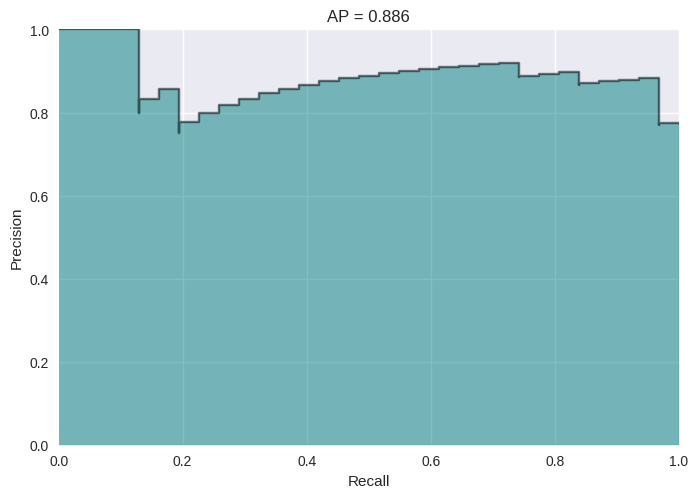

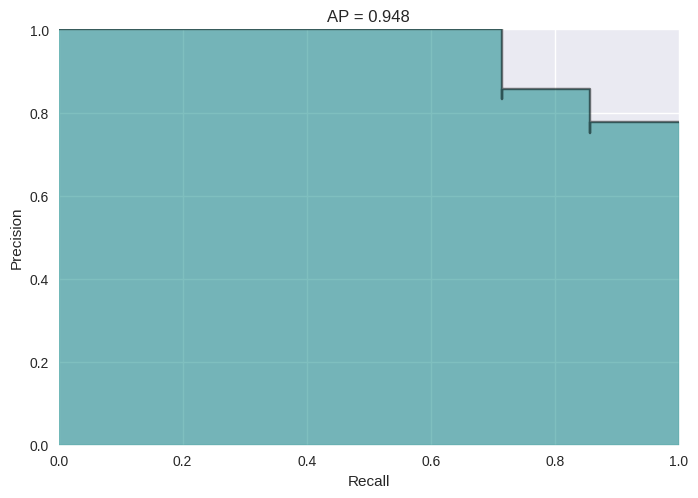

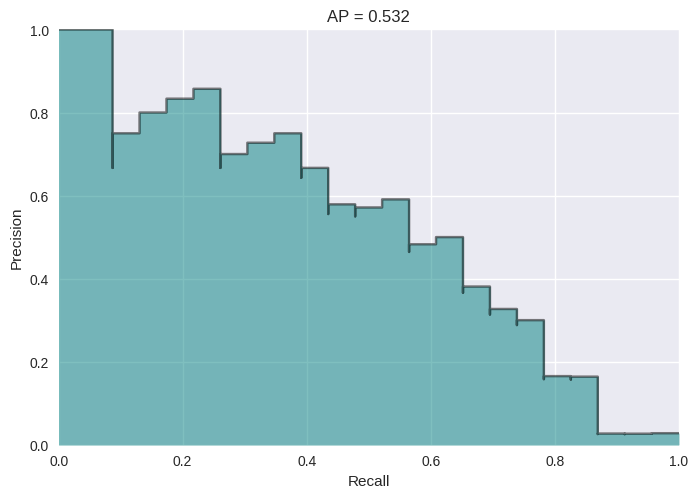

In [100]:
def hist_detect(paths, dist_func, nbins=16):
    score = np.zeros(len(paths), dtype=np.float32)

    prev_hist = None
    for idx, path in enumerate(paths):
        img = load_img(path, grey=True)
        cur_hist, _ = np.histogram(img, bins=nbins, density=True)
        cur_hist = cur_hist / nbins

        if idx >= 1:
            score[idx] = dist_func(prev_hist, cur_hist)

        prev_hist = cur_hist
        del img
    
    return score


# L1_score = hist_detect(xs_fr, L1)
L2_score = hist_detect(xs_fr, L2)
# df1, _ = pr_curve(ys_fr, L1_score)
df2, _ = pr_curve(ys_fr, L2_score)

# L1_score = hist_detect(xs_nw, L1)
L2_score = hist_detect(xs_nw, L2)
# df1, _ = pr_curve(ys_nw, L1_score)
df2, _ = pr_curve(ys_nw, L2_score)

# L1_score = hist_detect(xs_sc, L1)
L2_score = hist_detect(xs_sc, L2)
# df1, _ = pr_curve(ys_sc, L1_score)
df2, _ = pr_curve(ys_sc, L2_score)

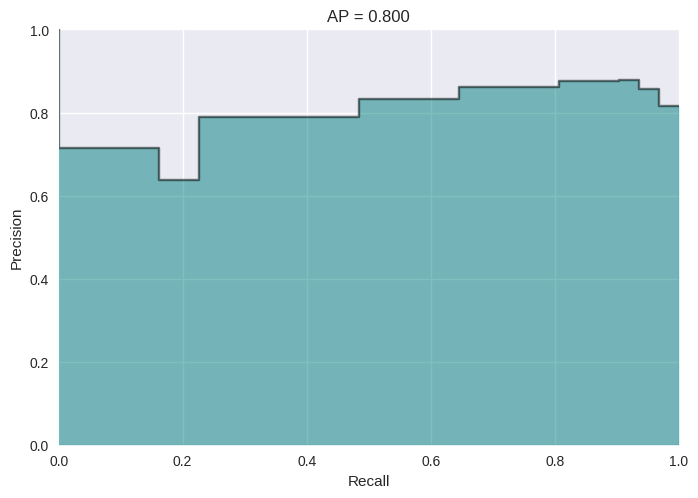

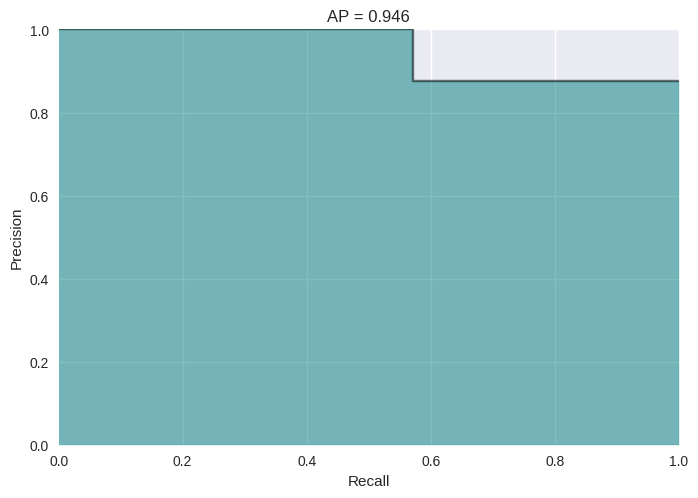

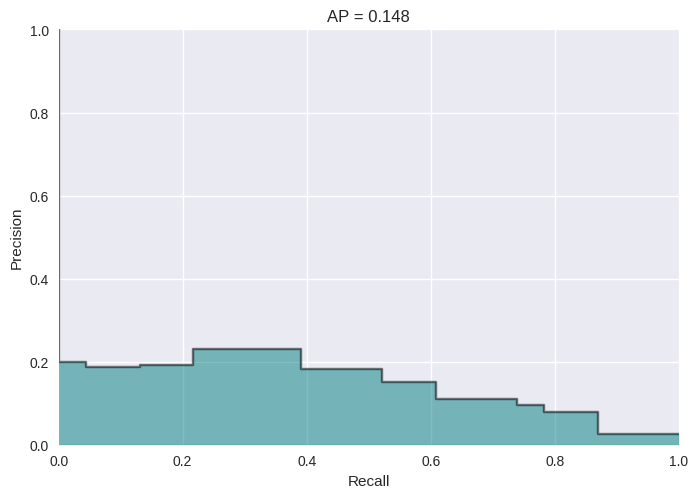

In [98]:
def split_to_blocks(x, nrows, ncols):
    res = []
    rows = np.vsplit(x, nrows)
    for row in rows:
        res.extend(np.hsplit(row, ncols))
    return np.array(res)

def block_diff(b1, b2):
    m1, s1 = np.mean(b1), np.var(b1)
    m2, s2 = np.mean(b2), np.var(b2)
    nem = ((s1 + s2) / 2 + ((m1 - m2) / 2)**2)**2
    den = s1 * s2
    return nem / den

def frame_score(blocks1, blocks2, th):
    N = len(blocks1)
    diffs = np.zeros(N, dtype=np.float32)
    for i, b1, b2 in zip(range(N), blocks1, blocks2):
        diffs[i] = block_diff(b1, b2)      
    return np.sum(diffs > th)

def likelihood_detect(paths, th=1.001):
    score = np.zeros(len(paths), dtype=np.float32)
    pre = None
    
    for i, path in enumerate(paths):
        img = load_img(path, grey=True)
        cur = split_to_blocks(img, 4, 4)
        
        if i >= 1:
            score[i] = frame_score(cur, pre, th)
        
        pre = cur
        
    return score

score = likelihood_detect(xs_fr, 1.01)
df, _ = pr_curve(ys_fr, score)
score = likelihood_detect(xs_nw, 1.0001)
df, _ = pr_curve(ys_nw, score)
score = likelihood_detect(xs_sc, 1.0001)
df, _ = pr_curve(ys_sc, score)